## EDA Data

In [ ]:
# !pip install fastparquet

In [1]:
import pandas as pd
import plotly.express as px
data = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet")

Набор данных содержит сделующи колонки:
played_ratio_pct	track_length_seconds	event_type

In [2]:
data.head()

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
0,100,39420,8326270,0,100.0,170.0,listen
1,100,39420,1441281,0,100.0,105.0,listen
2,100,39625,286361,0,100.0,185.0,listen
3,100,40110,732449,0,100.0,240.0,listen
4,100,40360,3397170,0,46.0,130.0,listen


### Распределение данных

#### timestamp

In [3]:
HOUR_SECONDS = 60 * 60
DAY_SECONDS = 24 * HOUR_SECONDS


print("Дней в данных:", (data["timestamp"].max() - data["timestamp"].min())//DAY_SECONDS)

Дней в данных: 300


#### event_type

Несмотря на то, что в документации описаны типы событий, повторно посмотрим какие есть и в какой количестве

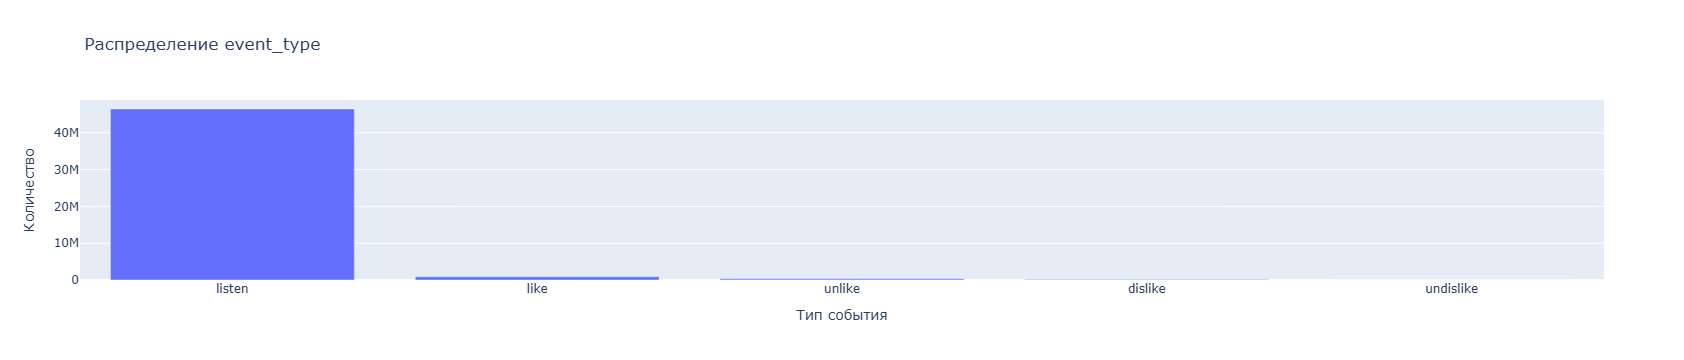

In [3]:


fig = px.bar(
    data["event_type"].value_counts().reset_index(),
    x="index",
    y="event_type",
    labels={"index": "Тип события", "event_type": "Количество"},
    title="Распределение event_type"
)

fig.show()

Можно выделить 2 типа взаимодействия пользователя с аудиодоржной: явные (explicit) - like, unlike, dislike, undislike. Такой тип оценки надержный, он явно показывает понравилась ли песня пользователю или нет.

Другой тип - неявные (implicit) - listen. Таких взаиводейтсвий намного больше, но они не надежные, прослушанная песня еще не признак того, что она понравилась пользователю.

#### track_length_seconds

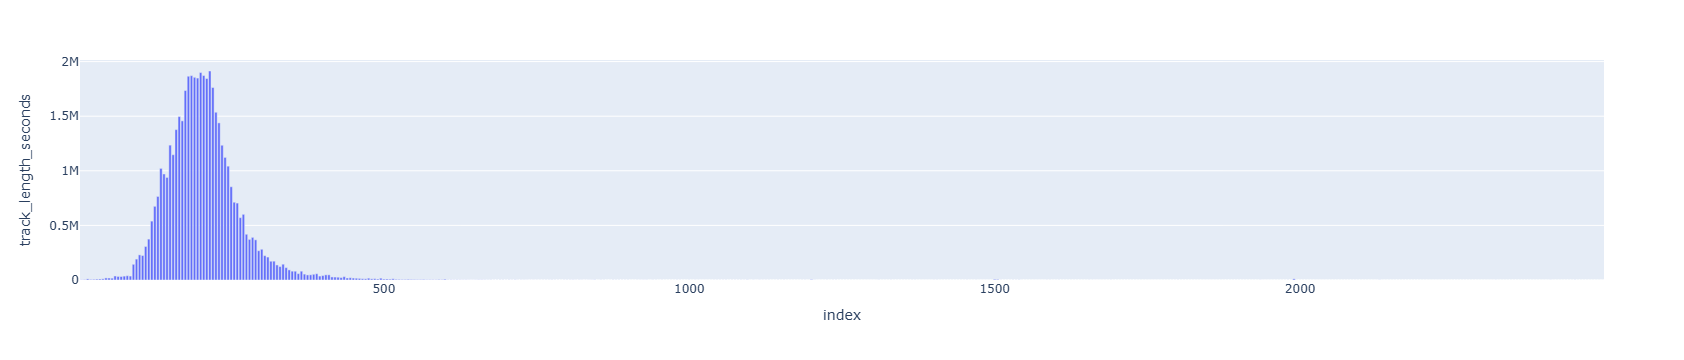

In [4]:
df_listen = data[data["event_type"] == "listen"]

fig = px.bar(
    df_listen["track_length_seconds"].value_counts().reset_index(),
    x="index",
    y="track_length_seconds"
)

fig.show()


Скорее всего это подкасты или склейки. Вероятность прослушивания таких долгих песен сильно ниже и может негативно повлиять на статистику. Поэтому такие песни удаляются из работы. Но такое будем применять только для обучающей выборки 

#### played_ratio_pct

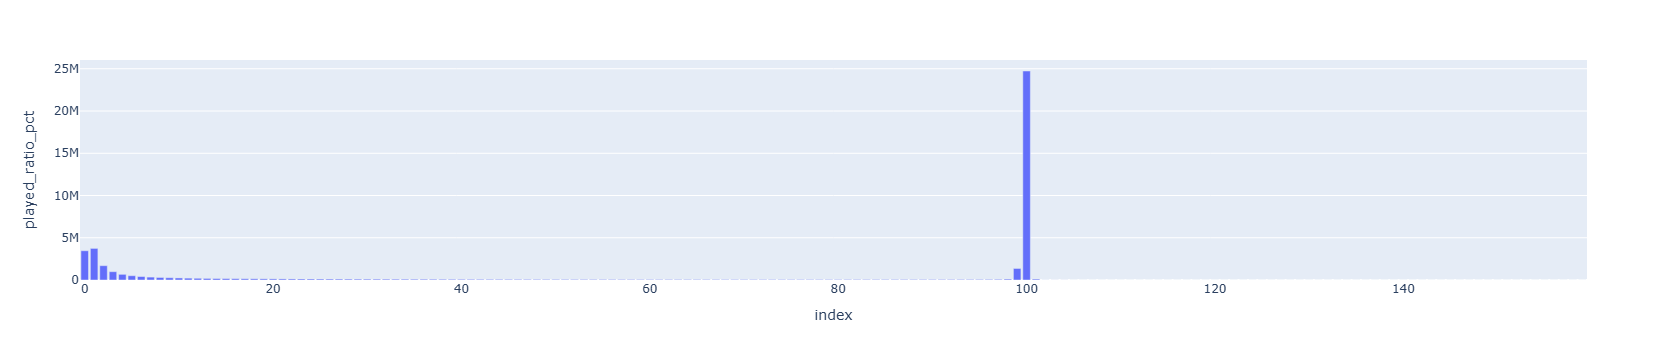

In [7]:
fig = px.bar(
    df_listen["played_ratio_pct"].value_counts().reset_index(),
    x="index",
    y="played_ratio_pct"
)

fig.show()


В столбце played_ratio_pct обнаружены значения, превышающие 100 %, что невозможно с точки зрения логики прослушивания. Такие записи следует полностью удалить, поскольку они являются ошибочными.

В то же время крайне малые значения played_ratio_pct встречаются тогда, когда пользователь быстро перелистывает трек, и факт прослушивания фиксируется лишь на долю секунды. Такие случаи являются валидными, поэтому мы оставляем их в датасете.

In [11]:
len(data[data["played_ratio_pct"]>50])/len(data)

0.6145661238713199

In [10]:
len(data[data["played_ratio_pct"]<20])/len(data)

0.2962495288546044

#### item_id

In [5]:
df_listen["item_id"].value_counts()

5862961    41984
6901374    40776
3542184    39947
9378983    38819
5635052    38804
           ...  
5976362        1
6124490        1
8479009        1
7915502        1
7109018        1
Name: item_id, Length: 877168, dtype: int64

В данных встречаются треки, которые были прослушаны всего один–два раза. Такие записи могут вносить шум и искажать распределение, поэтому их желательно исключить из обучающей выборки. При этом важно не удалять их из тестового набора, чтобы не нарушать корректность финальной оценки модели.

Также из обучающей выборки следует убрать треки, которых нет в системе (например, отсутствуют embedding или метаданные). Эти случаи стоит фиксировать отдельно и при необходимости рассчитывать по ним дополнительную метрику.

#### uid

In [7]:
df_listen["uid"].value_counts()

83700     27617
997500    27496
358100    27292
990300    27244
509900    27178
          ...  
85800        11
578700       11
231900        8
111100        7
65700         6
Name: uid, Length: 9238, dtype: int64

Аналогично трекам, из обучающей выборки стоит исключить пользователей с очень малым числом прослушиваний — по ним невозможно построить устойчивые предпочтения, и такие данные могут ухудшать качество модели. Однако удалять таких пользователей из тестовой выборки нельзя: это реальная ситуация, и система должна уметь работать даже с новыми или малозаметными пользователями, для которых данных практически нет.

### Дубликаты

#### listen

In [3]:
df_listen_dup = data[data["event_type"] == "listen"][:3000]

dupes = df_listen_dup[
    df_listen_dup.duplicated(
        subset=["uid", "item_id", "event_type", "timestamp"],
        keep=False
    )
].sort_values(["uid", "item_id", "timestamp"])

dupes


,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
2102,100,12931240,410868,1,0.0,245.0,listen
2104,100,12931240,410868,1,0.0,245.0,listen
2792,100,22858855,5114754,0,37.0,130.0,listen
2793,100,22858855,5114754,1,4.0,130.0,listen
731,100,5520685,5338928,0,0.0,200.0,listen
737,100,5520685,5338928,0,100.0,200.0,listen
732,100,5520685,5527368,0,0.0,235.0,listen
736,100,5520685,5527368,0,100.0,235.0,listen
1759,100,8720300,8437556,1,1.0,145.0,listen
1760,100,8720300,8437556,1,74.0,145.0,listen


Было обнаружено, что дублирующиеся строки не полностью идентичны — у них различается показатель played_ratio_pct. Это означает, что одно и то же событие фиксировалось несколько раз, но с разной долей прослушивания. Поэтому удалять такие дубликаты нужно аккуратно: для каждой группы дублей следует сохранять только последнюю запись с максимальным значением played_ratio_pct, а остальные удалять.

Проверим остальные столбцы. Поле is_organic не должно различаться для одинаковых событий — оно должно иметь единое значение. Однако в данных встречаются ситуации, когда is_organic расходится для дублей. Чтобы корректно обработать такие случаи, возьмём среднее значение is_organic для каждой группы повторяющихся строк.

Если после усреднения получается значение 0.5, это означает, что строка встречалась дважды с разными значениями признака. Такие записи считаем неконсистентными и удаляем.

In [6]:
conflicts = (
    df_listen_dup.groupby(["uid", "item_id", "event_type", "timestamp"])["is_organic"]
    .nunique()
    .reset_index(name="unique_values")
)

conflicts = conflicts[conflicts["unique_values"] > 1]
conflicts.head()

,uid,item_id,event_type,timestamp,unique_values
1664,100,5114754,listen,22858855,2


Отрисуем только активность прослушивания и окрасим разными цветами разные item_id

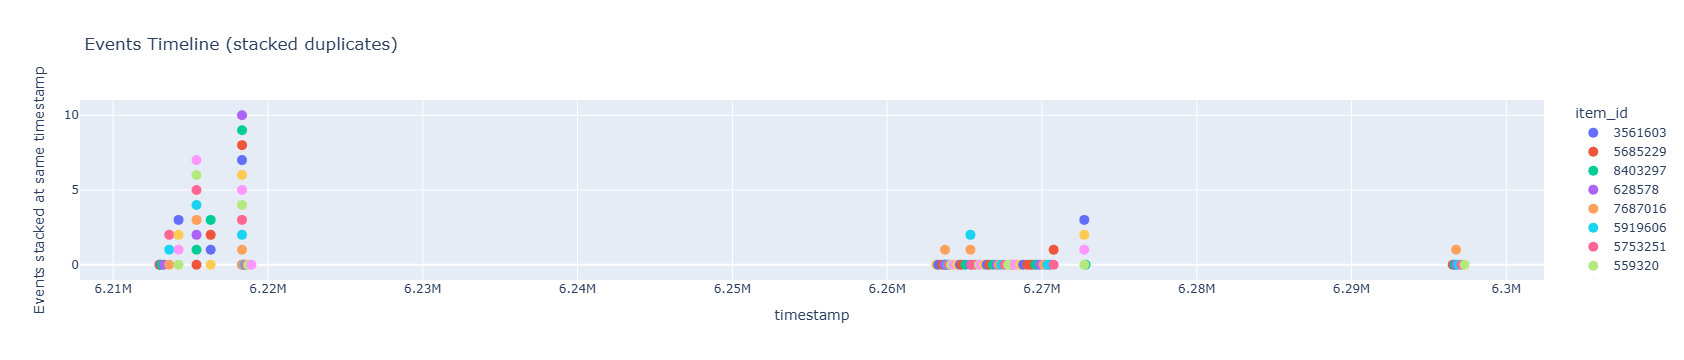

In [14]:
import plotly.express as px
import pandas as pd

df = data[(data["uid"] == 100) & (data["event_type"] == "listen")].sort_values("timestamp")[900:1000]
# df = data[(data["uid"] == 997500) & (data["event_type"] == "listen")].sort_values("timestamp")#[3021:3100]


df["count_sec"] = df["track_length_seconds"]*df["played_ratio_pct"]*0.01

df["stack_level"] = df.groupby("timestamp").cumcount()

fig = px.scatter(
    df,
    x="timestamp",
    y="stack_level",
    color="item_id",

    hover_data=["event_type", "timestamp", "count_sec"],
    
    title="Events Timeline (stacked duplicates)"
)


fig.update_traces(marker=dict(size=10))
fig.update_yaxes(title="Events stacked at same timestamp", showgrid=True)
fig.show()


Почему в одно время может быть зафиксировано несколько событий
* событие было очень быстрое (пролистывание) и оно поместилось в 1 timestamp
* несколько человек пользуются одним аккаунтом
* ошибка

Для первой итерации такие случаеи будут удаляться, потом стоит добавить обработку коротких событий (прослушиваний) 
После удаления точность не просела 

#### like/unlike/dislike/unlike

In [8]:
df_like = data[data["event_type"] != "listen"]

df_like[(df_like["uid"] == 900)&
        # (df_like["timestamp"] == 25457490)&
        (df_like["item_id"] == 3385274)&
        ~(df_like["event_type"] == "listen")][["timestamp", "event_type"]].value_counts()

timestamp  event_type
25457490   unlike        16
           like          16
25457460   like           1
25457470   unlike         1
25457480   like           1
25457485   unlike         1
           like           1
25514485   dislike        1
25514645   like           1
dtype: int64

В данных встречаются ситуации, когда в один и тот же момент времени зафиксировано несколько лайков и дизлайков подряд. Причины могут быть разными: пользователь мог несколько раз нажать на кнопку, произошёл интерфейсный сбой, либо пользователь изменил своё мнение — например, сначала поставил лайк, затем убрал его, а позже снова поставил.

Чтобы корректно обрабатывать такие случаи, для каждой группы событий будем оставлять только последнее зафиксированное действие, определяя его по максимальному индексу строки (поскольку timestamp может быть округлён и не всегда отражает точный порядок событий).

В каждом наборе данных мы обработаем поле event_type, определив итоговую реакцию пользователя. Последовательность событий интерпретируем следующим образом:

- like → like
- unlike → dislike
- dislike → dislike
- undislike → like

Важно выполнять эту логику отдельно для каждой выборки (train, test, val), поскольку мнение пользователя могло измениться после рекомендаций, и агрегировать по всему датасету нельзя.

#### Уникальность uid/item_id/timestapm

In [4]:
batch = data[data["uid"].isin(data["uid"].unique().tolist()[:300])]
conflicts = (
    batch
    .groupby(["uid", "timestamp"])["item_id"]
    .nunique()
    .reset_index(name="n_items")
    .query("n_items > 1")
)

conflicts

,uid,timestamp,n_items
0,100,39420,2
10,100,41580,2
11,100,42115,6
15,100,43425,5
16,100,43720,2
...,...,...,...
1019935,30000,25998430,2
1019936,30000,25998840,4
1019937,30000,25998900,3
1019940,30000,25999235,6


In [8]:
data[data["uid"] == 30000][812:]

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
1272923,30000,25999045,7857368,1,100.0,140.0,listen
1272924,30000,25999100,7682723,1,27.0,200.0,listen
1272925,30000,25999235,2479739,1,7.0,155.0,listen
1272926,30000,25999235,3049618,1,1.0,155.0,listen
1272927,30000,25999235,8578148,1,16.0,365.0,listen
1272928,30000,25999235,2978903,1,0.0,235.0,listen
1272929,30000,25999235,3049618,1,32.0,155.0,listen
1272930,30000,25999235,6051828,1,0.0,270.0,listen
1272931,30000,25999235,5167477,1,2.0,185.0,listen
1272932,30000,25999235,6051828,1,1.0,270.0,listen


In [12]:
25999255-25999235

20

### Целостность данных

In [9]:
data[data["uid"].isna() | data["item_id"].isna()]

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type


## Вывод 

| Шаг                                             | Где применяется                | Описание                                                                                           |
| ----------------------------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------- |
| **1. Обработка лайков и дизлайков**             | Train / Test отдельно          | Нормализуем последовательности реакций, оставляем последнюю корректную реакцию пользователя.       |
| **2. Фильтр по длине трека (60–300 сек)**       | Только Train                   | Удаляем слишком короткие и слишком длинные треки, чтобы не искажать обучение.                      |
| ~~3. Удаление played_ratio_pct > 100%~~         | ~~Везде~~                          | ~~Такие значения невозможны — полностью удаляем.~~ В документации авторов - это явление промотка трека                                                     |
| ~~4. Удаление дублей по прослушиванию~~         | ~~Везде~~                          | ~~Из-за округлённого timestamp встречаются повторяющиеся строки — оставляем только самую последнюю.~~ |
| **5. Удаление дублей лайков/дизлайков**         | Train / Test отдельно          | Сохраняем последнюю реакцию по индексу                       |
| **6. Удаление редких треков**                   | Только Train                   | Треки с очень малым числом прослушиваний убираются как шумовые.                                    |
| **7. Удаление треков, отсутствующих в системе** | Только Train (Test — оставить) | Из Train удаляем треки без embedding и метаданных; считаем метрику отдельно с ними и без них.      |
| **8. Удаление “редких” пользователей**          | Только Train                   | Пользователи с малым числом событий ухудшают обучение модели.                                      |
| **9. Метрики по новым пользователям**           | Только Test                    | Оцениваем модель отдельно на cold-start пользователях и на известных.                              |
| **10. Удаление одинаковых событий пользователя в один timestamp**           | Только Train                    | Возможная аномалия, удаляем дубликаты                               |
